In [1]:
import sys
sys.path.append(".")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
from Models import NeuralNetwork, LinearModel
from Datasets import ProfitDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

In [2]:
%reload_ext autoreload
%autoreload 2

# Pytorch' NN

## Linear regression with one variable 

In [3]:
dataset = ProfitDataset('ex1data1.txt')
population, profit = dataset.to_numpy()
N = 1
# M = 97
M = len(profit)
output_size = 1

torch.Size([97, 1])
torch.Size([97, 1])


In [4]:
population.shape, profit.shape

((97,), (97,))

In [5]:
for i in range(10):
    feature, y = dataset[i]
    print(f'Population: {feature}, Profit: {y}')

Population: tensor([6.1101], dtype=torch.float64), Profit: tensor([17.5920], dtype=torch.float64)
Population: tensor([5.5277], dtype=torch.float64), Profit: tensor([9.1302], dtype=torch.float64)
Population: tensor([8.5186], dtype=torch.float64), Profit: tensor([13.6620], dtype=torch.float64)
Population: tensor([7.0032], dtype=torch.float64), Profit: tensor([11.8540], dtype=torch.float64)
Population: tensor([5.8598], dtype=torch.float64), Profit: tensor([6.8233], dtype=torch.float64)
Population: tensor([8.3829], dtype=torch.float64), Profit: tensor([11.8860], dtype=torch.float64)
Population: tensor([7.4764], dtype=torch.float64), Profit: tensor([4.3483], dtype=torch.float64)
Population: tensor([8.5781], dtype=torch.float64), Profit: tensor([12.], dtype=torch.float64)
Population: tensor([6.4862], dtype=torch.float64), Profit: tensor([6.5987], dtype=torch.float64)
Population: tensor([5.0546], dtype=torch.float64), Profit: tensor([3.8166], dtype=torch.float64)


### Plotting de data

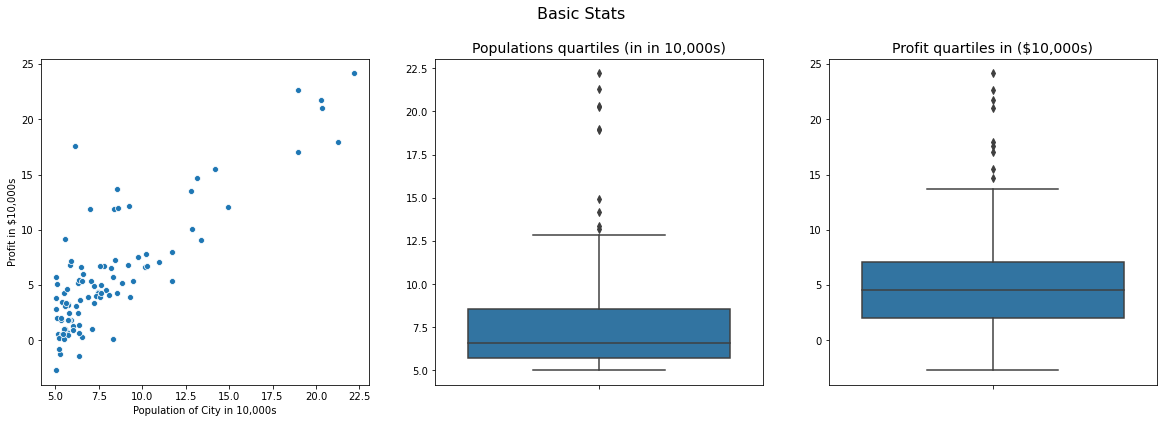

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Basic Stats', fontsize=16, y=1)

sns.scatterplot(x=population, y=profit, ax=ax1)
ax1.set_xlabel('Population of City in 10,000s')
ax1.set_ylabel('Profit in $10,000s')

sns.boxplot(y=population, ax=ax2)
ax2.set_title('Populations quartiles (in in 10,000s)', fontsize=14)

sns.boxplot(y=profit, ax=ax3)
ax3.set_title('Profit quartiles in ($10,000s)', fontsize=14)

plt.show()

### NN Model Class

In [7]:
torch.set_default_dtype(torch.double)

In [8]:
hidden_size = 6

### Training the net

In [9]:
model = LinearModel(N, hidden_size, 1)
# optimizer = optim.SGD(model.parameters(), lr=1e-2)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.MSELoss(reduction='mean')

In [18]:
model

LinearModel(
  (layer): Sequential(
    (0): Linear(in_features=1, out_features=6, bias=True)
    (1): ReLU()
    (2): Linear(in_features=6, out_features=1, bias=True)
  )
)

In [10]:
dataloader = DataLoader(dataset, batch_size=len(dataset))

In [11]:
# epochs = 1500
epochs = 1000
losses = []
for i in range(epochs):
    for x, y in dataloader:
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [12]:
losses

[41.7464966666984,
 17.33802029777829,
 12.218838547893894,
 11.775902352009048,
 11.741944592596662,
 11.732564981468041,
 11.723249918640589,
 11.713971277965403,
 11.704728412135152,
 11.695521053307544,
 11.686348942002242,
 11.677211822249907,
 11.668109441489241,
 11.659041550507482,
 11.65000790338043,
 11.64100825741354,
 11.632042373084232,
 11.623110013985434,
 11.614210946770307,
 11.605344941098206,
 11.596511769581733,
 11.58771120773492,
 11.578943033922554,
 11.570207029310488,
 11.56150297781707,
 11.552830666065532,
 11.544189883337404,
 11.535580421526872,
 11.527002075096126,
 11.51845464103157,
 11.509937918800969,
 11.501451710311494,
 11.492995819868561,
 11.484570054135583,
 11.4761742220945,
 11.467808135007111,
 11.459471606377207,
 11.451164451913447,
 11.44288648949299,
 11.434637539125852,
 11.426417422919991,
 11.418225965047059,
 11.410062991708847,
 11.401928331104404,
 11.393821813397812,
 11.385743270686547,
 11.377692536970525,
 11.369669448121702,
 11

In [13]:
x, y = iter(dataloader).next()

In [14]:
x.numpy().squeeze()

array([ 6.1101,  5.5277,  8.5186,  7.0032,  5.8598,  8.3829,  7.4764,
        8.5781,  6.4862,  5.0546,  5.7107, 14.164 ,  5.734 ,  8.4084,
        5.6407,  5.3794,  6.3654,  5.1301,  6.4296,  7.0708,  6.1891,
       20.27  ,  5.4901,  6.3261,  5.5649, 18.945 , 12.828 , 10.957 ,
       13.176 , 22.203 ,  5.2524,  6.5894,  9.2482,  5.8918,  8.2111,
        7.9334,  8.0959,  5.6063, 12.836 ,  6.3534,  5.4069,  6.8825,
       11.708 ,  5.7737,  7.8247,  7.0931,  5.0702,  5.8014, 11.7   ,
        5.5416,  7.5402,  5.3077,  7.4239,  7.6031,  6.3328,  6.3589,
        6.2742,  5.6397,  9.3102,  9.4536,  8.8254,  5.1793, 21.279 ,
       14.908 , 18.959 ,  7.2182,  8.2951, 10.236 ,  5.4994, 20.341 ,
       10.136 ,  7.3345,  6.0062,  7.2259,  5.0269,  6.5479,  7.5386,
        5.0365, 10.274 ,  5.1077,  5.7292,  5.1884,  6.3557,  9.7687,
        6.5159,  8.5172,  9.1802,  6.002 ,  5.5204,  5.0594,  5.7077,
        7.6366,  5.8707,  5.3054,  8.2934, 13.394 ,  5.4369])

### Validating the net

In [15]:
with torch.no_grad():
    y_train_pred = model(x)
    #y_test_pred = model(x_test_tensor)

In [16]:
#y_train_pred = np.squeeze(y_train_pred.detach().numpy())
score_train = r2_score(y, y_train_pred)
print(f'Score in training: {score_train}')

Score in training: 0.701374810850989


In [22]:
y_test_pred = np.squeeze(y_test_pred.detach().numpy())
score_test = r2_score(y_test, y_test_pred)
print(f'Score in training: {score_test}')

NameError: name 'y_test_pred' is not defined

### Plotting results

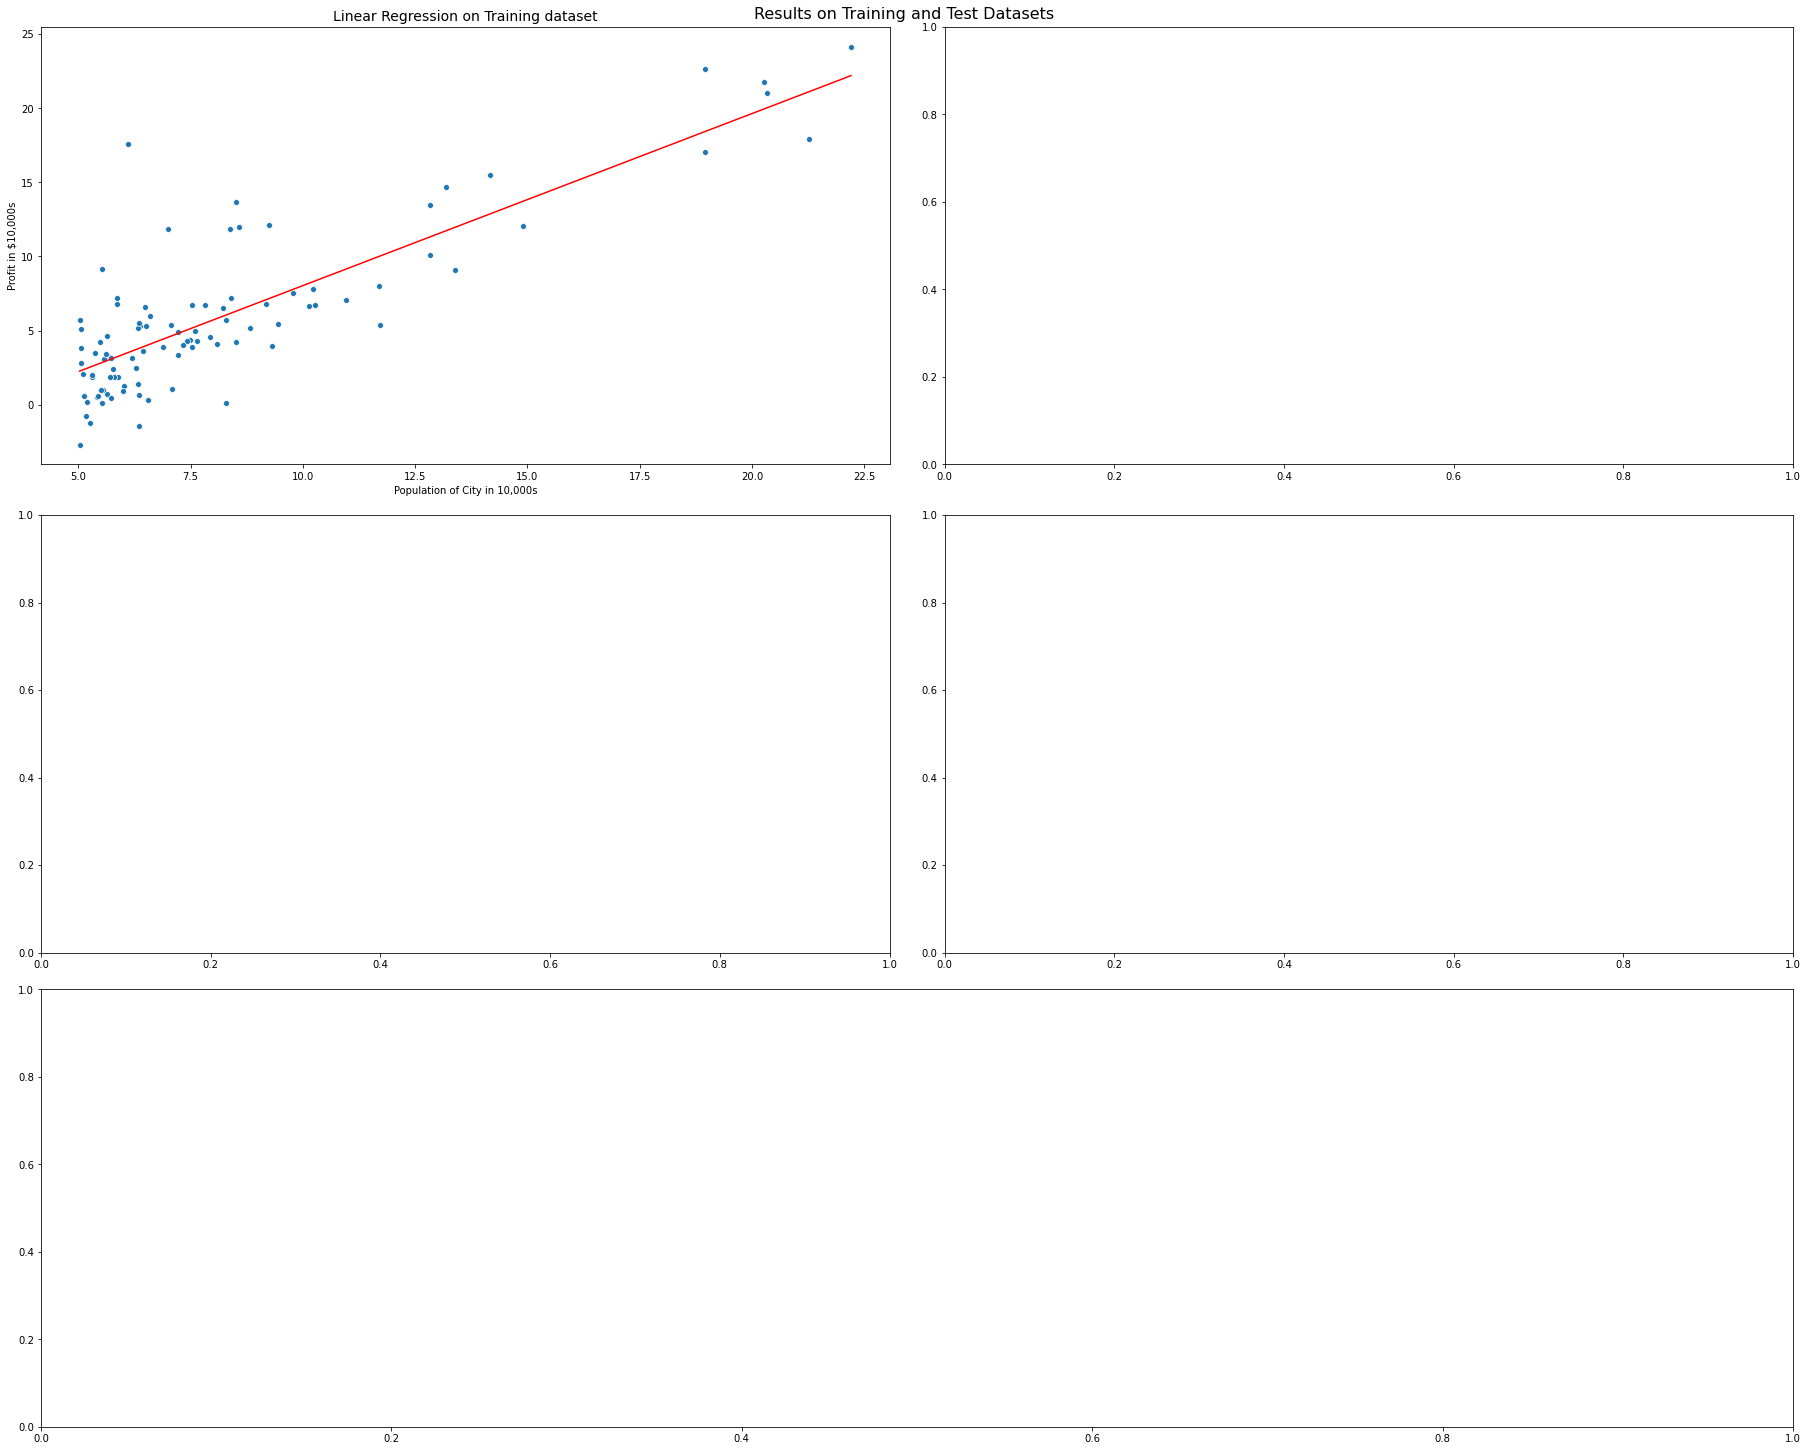

In [17]:
#fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(3, 2, figsize=(25, 15))
fig = plt.figure(constrained_layout=True, figsize=(25, 20))
spec = gridspec.GridSpec(ncols=2, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, :])

fig.suptitle('Results on Training and Test Datasets', fontsize=16, y=1)

ax1.set_title('Linear Regression on Training dataset', fontsize=14)
sns.scatterplot(x=x.numpy().squeeze(), y=y.numpy().squeeze(), ax=ax1)
ax1.set_xlabel('Population of City in 10,000s')
ax1.set_ylabel('Profit in $10,000s')
sns.lineplot(x.numpy().squeeze(), y_train_pred.numpy().squeeze(), color='red', ax=ax1)
"""
ax2.set_title('Linear Regression on Test dataset', fontsize=14)
sns.scatterplot(x=x_test, y=y_test, ax=ax2)
ax2.set_xlabel('Population of City in 10,000s')
ax2.set_ylabel('Profit in $10,000s')
sns.lineplot(x_test, y_test_pred, color='red', ax=ax2)

sns.lineplot(y=y_train_pred, x=range(len(y_train_pred)), ax=ax3, label='Prediction')
sns.lineplot(y=y_train, x=range(len(y_train)), ax=ax3, label='Actual')
ax3.set_title('Prediction on Train dataset', fontsize=14)

sns.lineplot(y=y_test_pred, x=range(len(y_test_pred)), ax=ax4, label='Prediction')
sns.lineplot(y=y_test, x=range(len(y_test)), ax=ax4, label='Actual')
ax4.set_title('Prediction on Test dataset', fontsize=14)

sns.lineplot(y=losses, x=range(len(losses)), ax=ax5)
ax5.set_xlabel('Epoch')
ax5.set_ylabel('Loss')
"""
plt.show()